In [1]:
# ! pip install cvxopt

In [2]:
# ! pip install latex

In [1]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
from sklearn import svm
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(13, 7.5)})
sns.set_context('talk')

In [3]:
import cv2
def picture(path):
    im = cv2.imread(str(path))
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([]) # hide x axis (hide the horizontal axis)
    cur_axes.axes.get_yaxis().set_ticks([])
    plt.imshow(im)
    return    

# Generate random data

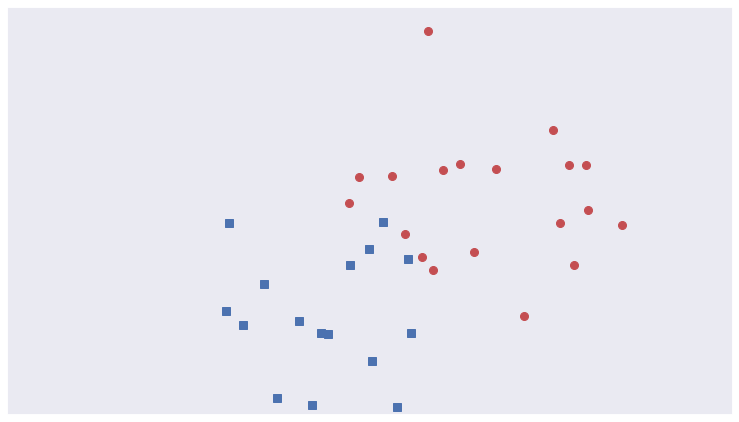

In [4]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# list of points 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages
np.random.seed(22)

means = [[2, 1], [4, 2]]
cov = [[.7, 0], [0, .7]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N) # each row is a data point 
X1 = np.random.multivariate_normal(means[1], cov, N)

with PdfPages('data.pdf') as pdf:
    plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1) # data point blue
    plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1) # data point red
    plt.axis('equal')
    plt.ylim(0, 4)
    plt.xlim(0, 5)

    # plt.xlabel('$x_1$', fontsize = 20)
    # plt.ylabel('$x_2$', fontsize = 20)

    # # hide tikcs 
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([]) # hide x axis (hide the horizontal axis)
    cur_axes.axes.get_yaxis().set_ticks([]) # hide y axis (hide vertical axis)

    #pdf.savefig()
    #plt.savefig('logistic_2d.png', bbox_inches='tight', dpi = 300)
    plt.show()

In [5]:
X = np.vstack((X0, X1)) # Nối 2 array thành 1 matrix dạng [X0,
                        #                                  X1]
y = np.vstack((np.ones((N,1 )), -np.ones((N,1 )))).reshape((2*N,))
# gắn nhãn y : 20 điểm đầu tiên np.ones((N,1 )) --> 1
#              20 điểm dữ liệu tiếp theo -np.ones((N,1 )) --> -1

In [6]:
#3 Solving by sklearn
from sklearn.svm import SVC
C = 100
clf = SVC(kernel = 'linear', C = C)
clf.fit(X, y) 

w_sklearn = clf.coef_.reshape(-1, 1) # giá trị w chuyển về dạng (-1,1) --> ma trận 1 cột
b_sklearn = clf.intercept_[0]        # giá trị b

In [7]:
print(w_sklearn, '\n', b_sklearn)

[[-4.81413725]
 [-5.96033961]] 
 22.70752936411212


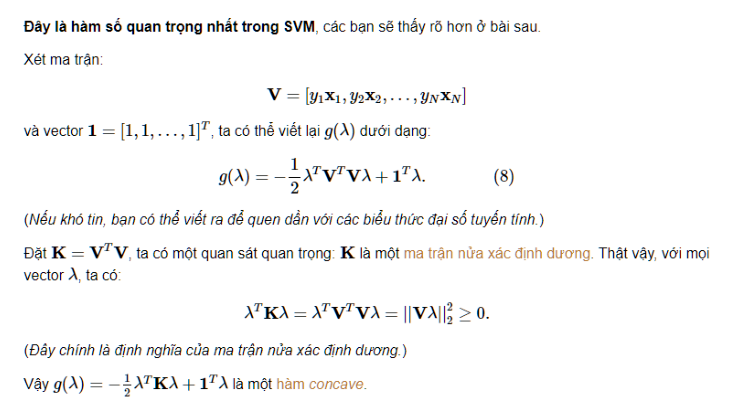

In [8]:
picture('SVM CT.png')

In [9]:
#By dual problems
from cvxopt import matrix, solvers
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1) # Nối 2 matrix  V = [X0, V shape = (len(X0),2)
K = matrix(V.T.dot(V))  # (K = V * V.T)                    #     X1]  

p = matrix(-np.ones((2*N, 1))) # 40 giá trị -1 p.shape = (1,40) Vector 1
# build A, b, G, h 
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N)))) # -np.eye(2*N) matrix đối xứng 
# for all lambda_n >= 0 H,G matrix hệ số của pt ràng buộc
h = np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))) # matrix 0 shape (80,1)

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N))) # the equality constrain is actually y^T lambda = 0
# matrix dx bán xd dương
b = matrix(np.zeros((1, 1)))

solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b) # Solve by quadratic programming

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[8.62798711e-08 4.41552718e-07 9.04861151e-08 1.52858925e-07
  1.89884560e-07 1.66410382e-07 2.53998475e+01 2.26556582e-07
  9.99999995e+01 1.66616199e-07 1.91844086e-07 1.66996427e-07
  9.99999990e+01 6.38734393e-07 1.13020400e-07 1.48447237e-07
  1.56704849e-07 1.13365415e-07 1.71435199e-07 1.00298560e-07
  1.74874274e-07 8.92661407e-08 4.24170767e-07 8.43400056e-07
  9.99999940e+01 8.98267639e-08 1.63290804e-07 1.37383609e-07
  1.97232416e-07 3.88459894e-07 8.22388339e-07 7.57984967e-08
  9.99999876e+01 1.36706782e-07 8.69363928e-08 1.10913948e-07
  2.43882100e-06 9.58891599e-08 1.03634166e-07 2.53998614e+01]]


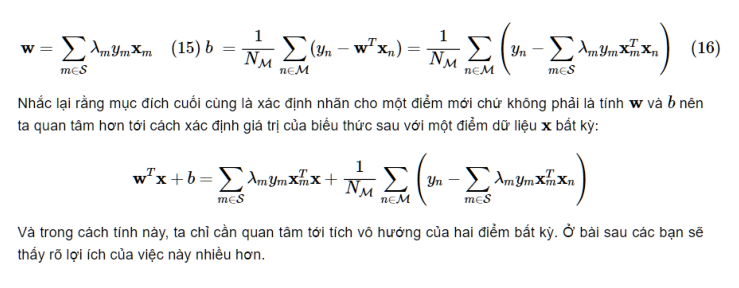

In [10]:
picture('SVM_CT2.png')

In [12]:
S = np.where(l > 1e-5)[0] # Vị trí các điểm có lamda > 0 (support set) 
S2 = np.where(l < .99*C)[0] # các điểm nằm trong vùng an toàn

M = [val for val in S if val in S2] # intersection of two lists (Các điểm nằm trên margin)
XT = X.T # we need each col is one data point in this alg
VS = V[:, S] # Tọa độ các điểm tại vị trí các điểm S (support set)
# XS = XT[:, S]
# yS = y[ S]
lS = l[S] # lamda tại các điểm là support set
# lM = l[M]
yM = y[M] # Nhãn tại các vị Trí M
XM = XT[:, M]
w_dual = VS.dot(lS).reshape(-1, 1)  # w = x*l*y
b_dual = np.mean(yM.T - w_dual.T.dot(XM)) # b = mean (y - wx)
print(w_dual,'\n',b_dual)

[[-4.81421922]
 [-5.96031548]] 
 22.707762945911483


# Hinge Loss

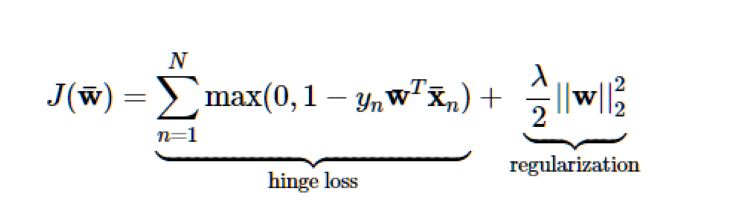

In [15]:
picture('SVM_CT5.png')

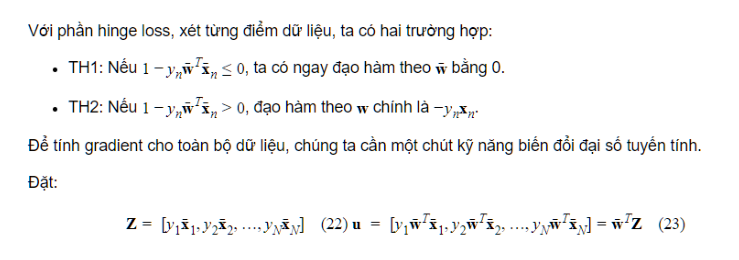

In [16]:
picture('SVM_CT3.png')

In [18]:
#Solving by Hinge loss
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
            .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1]
 
def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1]
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps
        wm[i] -= eps
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g

X0_ext = X0_bar
w0 = np.random.randn(X0_ext.shape[0], 1) 
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient difference: %f' %diff)

Gradient difference: 0.000000


Vì sự khác nhau giữa hai cách tính gradient là bằng 0, ta có thể yên tâm rằng gradient tính được là chính xác.

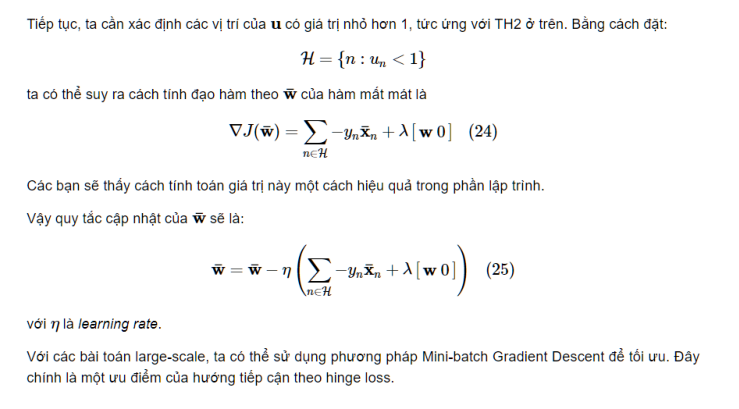

In [ ]:
picture('SVM_CT4.png')

In [19]:
def grad_descent(w0, eta):
    w = w0
    it = 0 
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g  # Cập nhập w
        if (it % 10000) == 1: # in kết quả sau khi chạy 10000 lần
            print('iter %d' %it + ' cost: %f' %cost(w)) # Show Cost
        if np.linalg.norm(g) < 1e-5:
            print('g:',np.linalg.norm(g))
            break
    return w 
w0 = np.random.randn(X0_ext.shape[0], 1) 
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]

iter 1 cost: 70.826831
iter 10001 cost: 5.669748
iter 20001 cost: 4.944371
iter 30001 cost: 4.819895
iter 40001 cost: 4.746380
iter 50001 cost: 4.670747
iter 60001 cost: 4.598705
iter 70001 cost: 4.528775
iter 80001 cost: 4.456803
iter 90001 cost: 4.387742


In [21]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

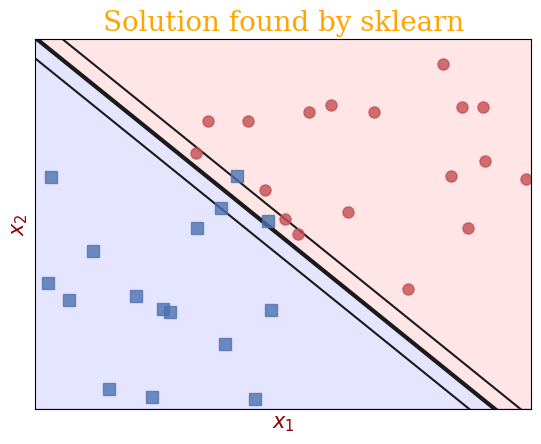

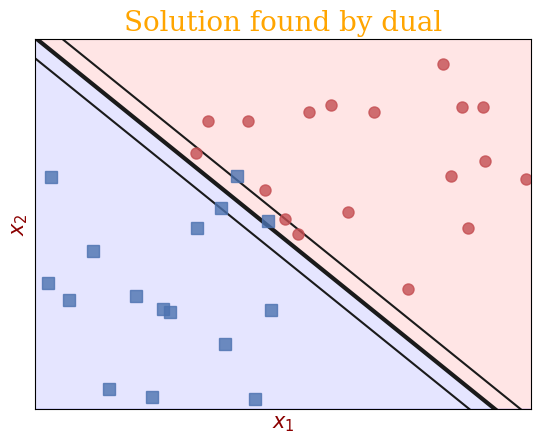

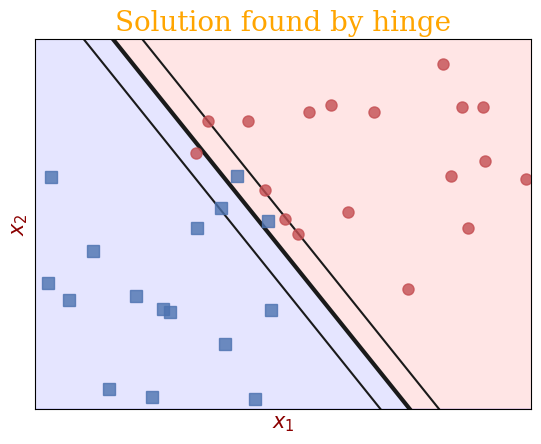

In [24]:
def myplot(X0, X1, w, b, filename, tit):
    with PdfPages(filename) as pdf:
        fig, ax = plt.subplots()
    
        w0 = float(w[0])
        w1 = float(w[1])
        x1 = np.arange(-10, 10, 0.1)
        y1 = -w0/w1*x1 - b/w1
        y2 = -w0/w1*x1 - (b-1)/w1
        y3 = -w0/w1*x1 - (b+1)/w1

        type1 = {'family':'serif','color':'orange','size':20}
        type2 = {'family':'serif','color':'darkred','size':15}

        
        plt.xlabel('$x_1$', fontdict = type2)
        plt.ylabel('$x_2$', fontdict = type2)
        plt.title('Solution found by ' + tit, fontdict = type1)
        # draw linear
        plt.plot(x1, y1, 'k', linewidth = 3)
        plt.plot(x1, y2, 'k')
        plt.plot(x1, y3, 'k')
        
        # fill two regions
        y4 = 10*x1
        plt.fill_between(x1, y1, color = 'blue', alpha= 0.1)
        plt.fill_between(x1, y1, y4, color = 'red', alpha = 0.1)

        # equal axis and lim
        plt.axis('equal')
        plt.ylim(0, 3)
        plt.xlim(2, 4)

        # hide tikcs 
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_ticks([])
        cur_axes.axes.get_yaxis().set_ticks([])
  
        plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = .8)
        plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = .8)
        #pdf.savefig()
        
        plt.show()

def f(x):
    return np.int(x)
f2 = np.vectorize(f)
import numpy as np
myplot(X0, X1, w_sklearn, b_sklearn, 'svm_sklearn.pdf', 'sklearn')
myplot(X0, X1, w_dual, b_dual, 'svm_dual.pdf', 'dual')
myplot(X0, X1, w_hinge, b_hinge, 'svm_hinge.pdf', 'hinge')
  

# Kenel SVM

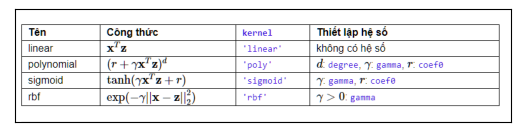

In [ ]:
picture('Kenel_CT1.png')

[0. 1. 1. 0.] [0 1] [0 1]
[0. 1. 1. 0.] [0 1] [0 1]
[0. 1. 1. 0.] [0 1] [0 1]


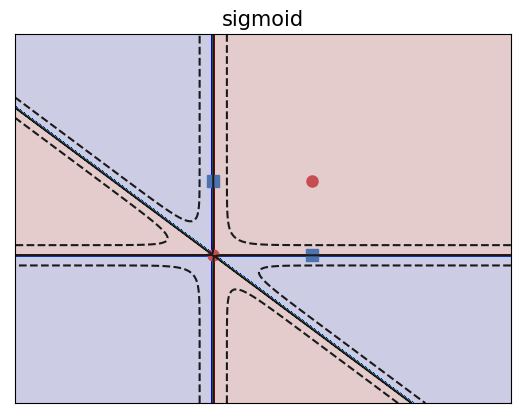

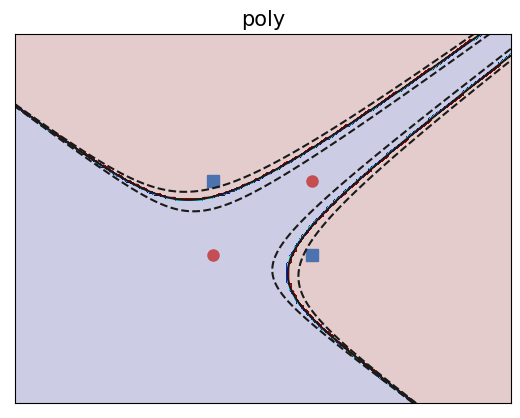

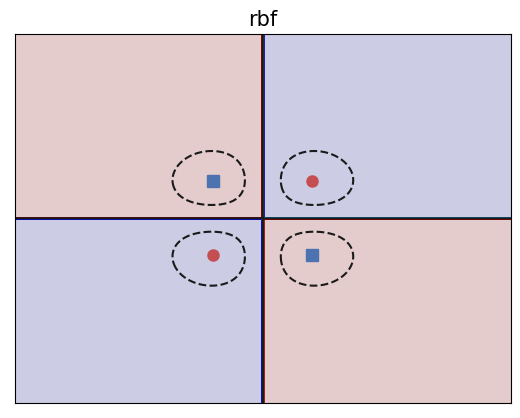

In [25]:
# XOR dataset and targets
X = np.c_[(0, 0),
          (1, 1),
          #---
          (1, 0),
          (0, 1)].T
Y = [0] * 2 + [1] * 2
# figure number
fignum = 1

# fit the model
for kernel in ('sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=4, coef0 = 0)
    clf.fit(X, Y)
    with PdfPages(kernel + '2.pdf') as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(4, 3))
        plt.clf()
        print(clf.support_vectors_[:, 0],X[:2, 0], X[:2, 1])
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                    facecolors='None') 
        plt.plot(X[:2, 0], X[:2, 1], 'ro', markersize = 8)
        plt.plot(X[2:, 0], X[2:, 1], 'bs', markersize = 8)

        plt.axis('tight')
        x_min, x_max = -2, 3
        y_min, y_max = -2, 3
        
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(4, 3))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        #pdf.savefig()
plt.show()

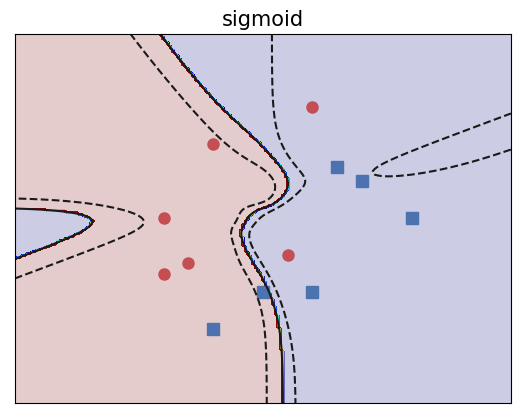

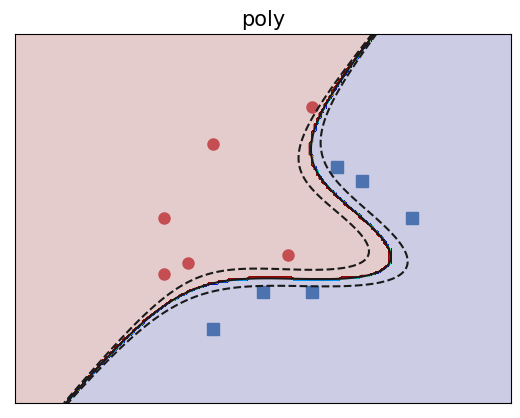

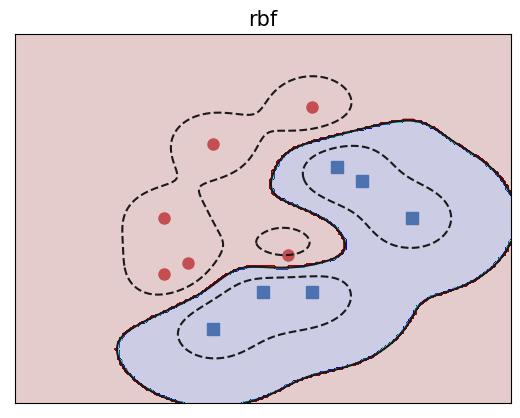

In [26]:
# XOR dataset and targets
X = np.c_[(-1, -3),
          (0, -2),
          (1, -2),
          (2, 1),
          (3, 0),
          (1.5, 1.4),
          #---
          (1, 3),
          (0.5, -1),
          (-1, 2),
          (-2, -1.5),
          (-2, 0),
          (-1.5, -1.2)].T
N = 6
Y = [0] * N + [1] * N
# figure number

# means = [[2, 2], [4, 2]]
# cov = [[.7, 0], [0, .7]]
# N = 20
# X0 = np.random.multivariate_normal(means[0], cov, N) # each row is a data point 
# X1 = np.random.multivariate_normal(means[1], cov, N)

# X = np.vstack((X0, X1))
# Y = [0]*N + [1]*N
fignum = 1

# fit the model
for kernel in ('sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(X, Y)
    with PdfPages(kernel + '3.pdf') as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(4, 3))
        plt.clf()

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                    facecolors='None')
        plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 8)
        plt.plot(X[N:, 0], X[N:, 1], 'ro', markersize = 8)

        plt.axis('tight')
        x_min = -5
        x_max = 5
        y_min = -5
        y_max = 5

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(4, 3))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        pdf.savefig()
plt.show()

In [27]:
import scipy.io as sio
from sklearn.metrics import accuracy_score

A = sio.loadmat('myARgender.mat')
X_train = A['Y_train'].T    
X_test = A['Y_test'].T 
N = 700
y_train = A['label_train'].reshape(N)   
y_test = A['label_test'].reshape(N)

clf = SVC(kernel='poly', degree = 3, gamma=1, C = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: %.2f %%" %(100*accuracy_score(y_test, y_pred)))

Accuracy: 92.86 %
